## Model Training for Denoised AutoEncoder

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
from tensorflow.python.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D,BatchNormalization
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.callbacks import ModelCheckpoint,EarlyStopping

# Set GPU memory limit to 3GB
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.75
sess = tf.Session(config=config)

# Load CIFAR-10 dataset
(x_train, _), (x_test, _) = tf.keras.datasets.cifar10.load_data()

# Normalize pixel values
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

 
# Add random noise to the images
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)



#Reshape training and noisy data to (50000, 32, 32, 3)
x_train = x_train.reshape(len(x_train), 32, 32, 3)
x_test = x_test.reshape(len(x_test), 32, 32, 3)

x_train_noisy = x_train_noisy.reshape(len(x_train_noisy), 32, 32, 3)
x_test_noisy = x_test_noisy.reshape(len(x_test_noisy), 32, 32, 3)



# Define the autoencoder architecture

##Encoder Part
input_img = Input(shape=(32, 32, 3))
x = Conv2D(128, (3, 3), activation='relu', padding='same')(input_img)
x = BatchNormalization()(x) 
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

##Decoder Part
x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = BatchNormalization()(x)
x = UpSampling2D()(x)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = UpSampling2D()(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = UpSampling2D()(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = UpSampling2D()(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)

decoded = Conv2D(3, (3, 3), padding='same')(x)



# Define the autoencoder model
autoencoder = Model(input_img, decoded,name = 'Denoising_Model')
autoencoder.summary()

# Compile the model
opt = tf.keras.optimizers.Adam(lr=0.001)
autoencoder.compile(optimizer=opt,
              loss=tf.keras.losses.mean_squared_error,
              metrics=['accuracy'])

# Train the model
checkpoint = ModelCheckpoint("Denoising_Model_Final.h5", save_best_only=True, save_weights_only=False, verbose = 1)
early_stopping=EarlyStopping(monitor='val_loss',patience=10,verbose=1,mode='min')

hist=autoencoder.fit(x_train_noisy, x_train,
                epochs=100,
                batch_size=128,
                callbacks = [checkpoint,early_stopping],shuffle=True, validation_split = 0.10)


H:\Anaconda\envs\V\lib\site-packages\tensorflow\python\framework\dtypes.py:469: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
H:\Anaconda\envs\V\lib\site-packages\tensorflow\python\framework\dtypes.py:470: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
H:\Anaconda\envs\V\lib\site-packages\tensorflow\python\framework\dtypes.py:471: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
H:\Anaconda\envs\V\lib\site-packages\tensorflow\python\framework\dtypes.py:472: FutureWarning: Passing (type, 1) or '1type' 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 128)       3584      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 128)       512       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        73792     
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 16, 64)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
__________

45000/45000 [==============================] - 48s - loss: 0.0119 - acc: 0.6802 - val_loss: 0.0119 - val_acc: 0.6769
Epoch 45/100
45000/45000 [==============================] - 48s - loss: 0.0118 - acc: 0.6799 - val_loss: 0.0117 - val_acc: 0.6800
Epoch 46/100
45000/45000 [==============================] - 48s - loss: 0.0119 - acc: 0.6796 - val_loss: 0.0119 - val_acc: 0.6568
Epoch 47/100
45000/45000 [==============================] - 48s - loss: 0.0117 - acc: 0.6810 - val_loss: 0.0117 - val_acc: 0.6662
Epoch 48/100
45000/45000 [==============================] - 49s - loss: 0.0117 - acc: 0.6802 - val_loss: 0.0115 - val_acc: 0.6867
Epoch 49/100
45000/45000 [==============================] - 49s - loss: 0.0117 - acc: 0.6806 - val_loss: 0.0116 - val_acc: 0.6573
Epoch 50/100
45000/45000 [==============================] - 49s - loss: 0.0117 - acc: 0.6802 - val_loss: 0.0116 - val_acc: 0.6802
Epoch 51/100
45000/45000 [==============================] - 49s - loss: 0.0116 - acc: 0.6818 - val_loss

45000/45000 [==============================] - 49s - loss: 0.0111 - acc: 0.6845 - val_loss: 0.0113 - val_acc: 0.6920
Epoch 77/100
45000/45000 [==============================] - 49s - loss: 0.0111 - acc: 0.6851 - val_loss: 0.0116 - val_acc: 0.6753
Epoch 78/100
45000/45000 [==============================] - 49s - loss: 0.0111 - acc: 0.6838 - val_loss: 0.0112 - val_acc: 0.6960
Epoch 79/100
45000/45000 [==============================] - 49s - loss: 0.0111 - acc: 0.6851 - val_loss: 0.0112 - val_acc: 0.6799
Epoch 80/100
45000/45000 [==============================] - 49s - loss: 0.0111 - acc: 0.6849 - val_loss: 0.0113 - val_acc: 0.6865
Epoch 81/100
45000/45000 [==============================] - 49s - loss: 0.0111 - acc: 0.6853 - val_loss: 0.0112 - val_acc: 0.6866
Epoch 82/100
45000/45000 [==============================] - 49s - loss: 0.0111 - acc: 0.6852 - val_loss: 0.0113 - val_acc: 0.6860
Epoch 83/100
45000/45000 [==============================] - 49s - loss: 0.0110 - acc: 0.6856 - val_loss

## Ploting the Accuracy and Loss Graph

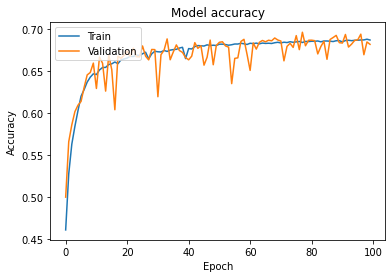

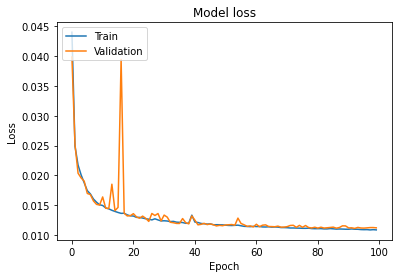

In [5]:
# Plot the test accuracy
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation', 'Test'], loc='upper left')
plt.show()

# Plot the test loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation', 'Test'], loc='upper left')
plt.show()

## Performing Evaluation Metrics

In [5]:
import tensorflow as tf
import numpy as np
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)


# Set GPU memory limit to 3GB
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.75
sess = tf.Session(config=config)

# Load CIFAR-10 dataset
(x_train, _), (x_test, _) = tf.keras.datasets.cifar10.load_data()

# Normalize pixel values
x_test = x_test.astype('float32') / 255.

 
# Add random noise to the images
noise_factor = 0.5
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)


autoencoder = tf.keras.models.load_model('Denoising_Model_Final.h5')

# Generate denoised images using the trained autoencoder
denoised_images = autoencoder.predict(x_test_noisy)

# Compute mean squared error (MSE)
mse = np.mean(np.square(x_test - denoised_images))


# Print the MSE 
print("MSE: {:.4f}".format(mse))

MSE: 0.0112


In [2]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import classification_report
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

(x_train, _), (x_test, _) = tf.keras.datasets.cifar10.load_data()

# Load the saved model
autoencoder = tf.keras.models.load_model('Denoising_Model_Final.h5')

# Add random noise to the images
noise_factor = 0.5
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)


#Reshape training and noisy data to (50000, 32, 32, 3)
x_test = x_test.reshape(len(x_test), 32, 32, 3)

x_test_noisy = x_test_noisy.reshape(len(x_test_noisy), 32, 32, 3)

# Evaluate the model on the test set
test_loss, test_accuracy = autoencoder.evaluate(x_test_noisy, x_test)

# Print the test loss and accuracy
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


10000/10000 [==============================] - 8s      ETA: 
Test Loss: 22982.151671875
Test Accuracy: 0.33795732421875


## Predicting on Test Images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

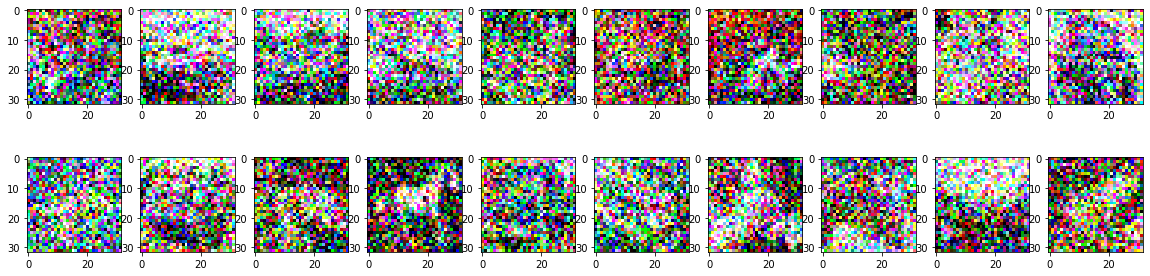

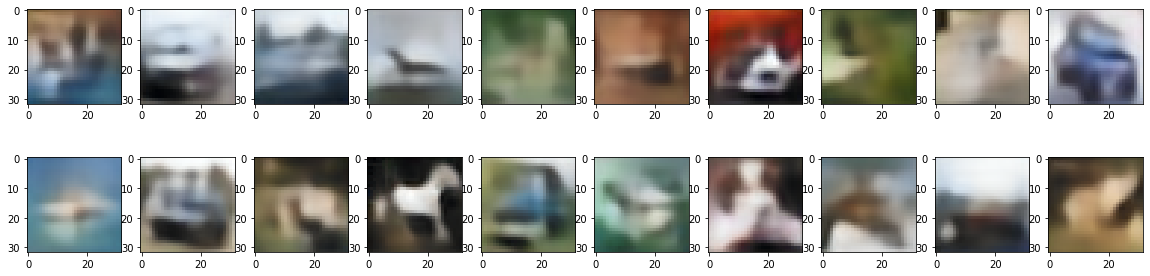

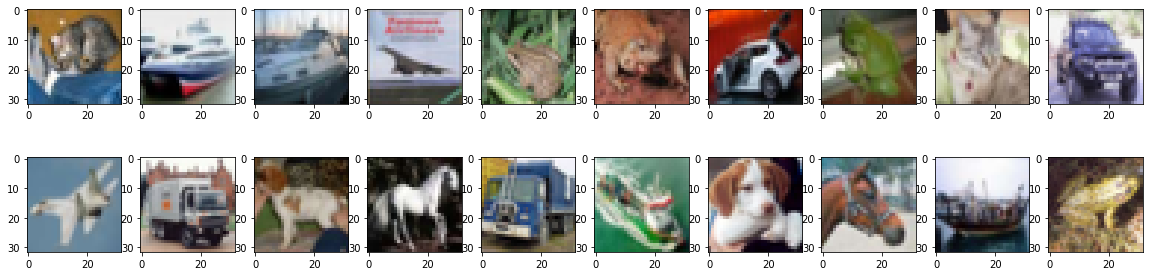

In [2]:
# Load the saved model
autoencoder = tf.keras.models.load_model('Denoising_Model_Final.h5')

## Function Definition
def visualize_data(data, row, column):
    data = data.reshape(data.shape[0], 32,32,3)
    count = 0
    fig, axes = plt.subplots(row, column, figsize = (20,5))
    for i in range(row):
        for j in range(column):
            axes[i,j].imshow(data[count], interpolation='nearest')
            count+=1


## FUnction call            
visualize_data(x_test_noisy[:20], 2,10)         ## Noisy data

pred = autoencoder.predict(x_test_noisy[:20]) 
visualize_data(pred, 2, 10)                     ##Denoised data

visualize_data(x_test[:20], 2,10)               ##Original input

## Predicting with our own image (Smaller Resolution)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

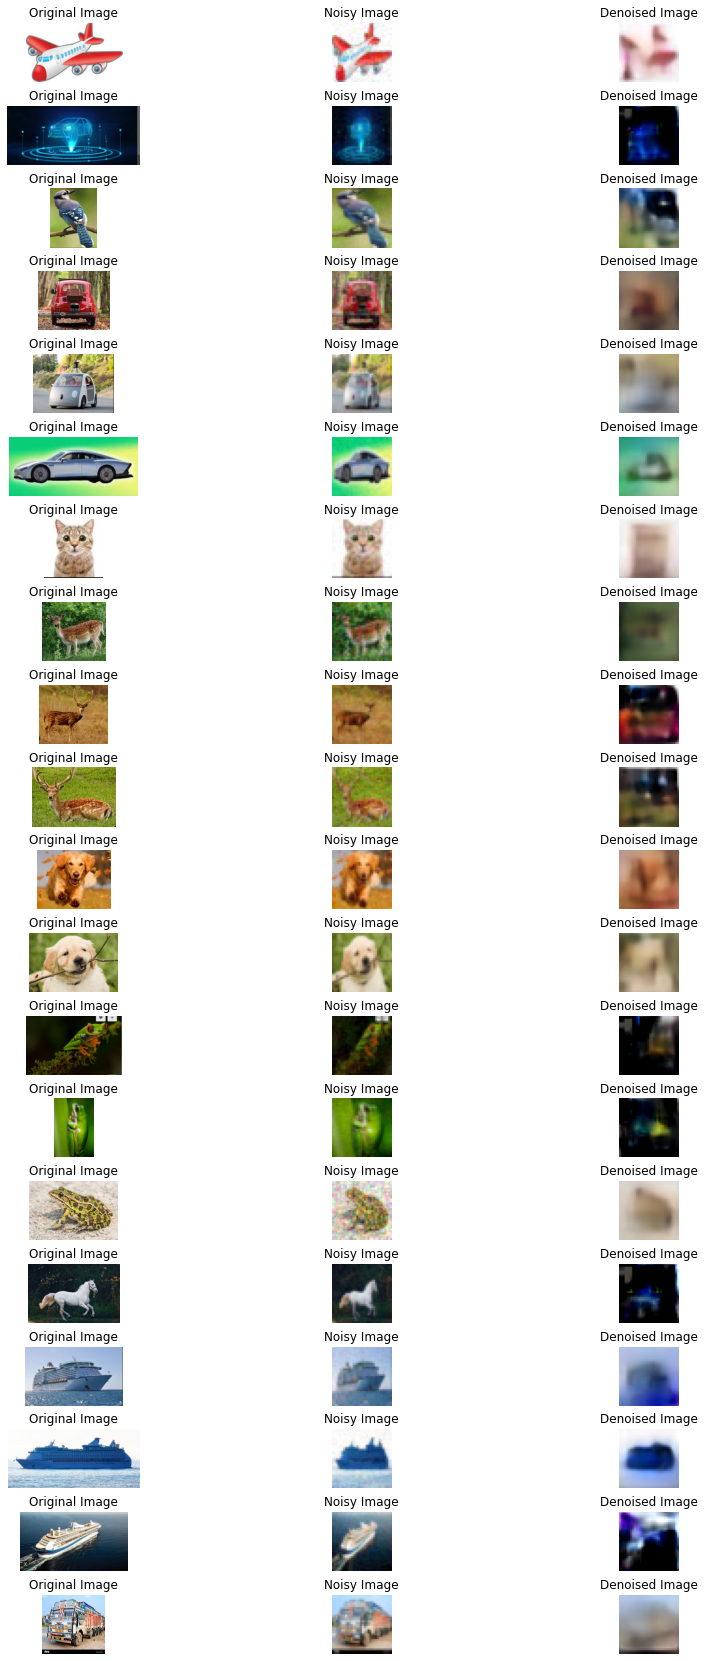

In [11]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from skimage.transform import resize

# Load the saved model
autoencoder = tf.keras.models.load_model('Denoising_Model_Final.h5')

# Set the path to the directory containing the images
image_dir = 'Images/'

# Loop through all image files in the directory
fig = plt.figure(figsize=(15,30))
counter = 0
for filename in os.listdir(image_dir):
    if filename.endswith('.jpg') or filename.endswith('.jpeg') or filename.endswith('.png') or filename.endswith('.JPG'):

        img_path = os.path.join(image_dir, filename)    
        # Load the image
        img = plt.imread(img_path)
        inpu=img.copy()

        img = img.astype('float32') / 255.

        ## Creating Noisy Image
        noise_factor = 0.5
        img = img + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=img.shape)

        # Resize the image to 32x32
        img_noisy = resize(img, (32, 32))

        # Preprocess the image
        img = np.reshape(img_noisy, (1, 32, 32, 3))

        # Denoise the image
        denoised_img = autoencoder.predict(img)

        # Display the original and denoised image side by side
        ax = fig.add_subplot(20, 3, counter*3+1)
        ax.imshow(inpu)
        ax.set_title("Original Image")
        ax.axis('off')
        
        ax = fig.add_subplot(20, 3, counter*3+2)
        ax.imshow(img_noisy)
        ax.set_title("Noisy Image")
        ax.axis('off')
        
        ax = fig.add_subplot(20, 3, counter*3+3)
        ax.imshow(denoised_img[0])
        ax.set_title("Denoised Image")
        ax.axis('off')

        counter += 1

plt.subplots_adjust(wspace=0.1, hspace=0.4)
plt.show()


## Predicting with our own image (Large Resolution)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

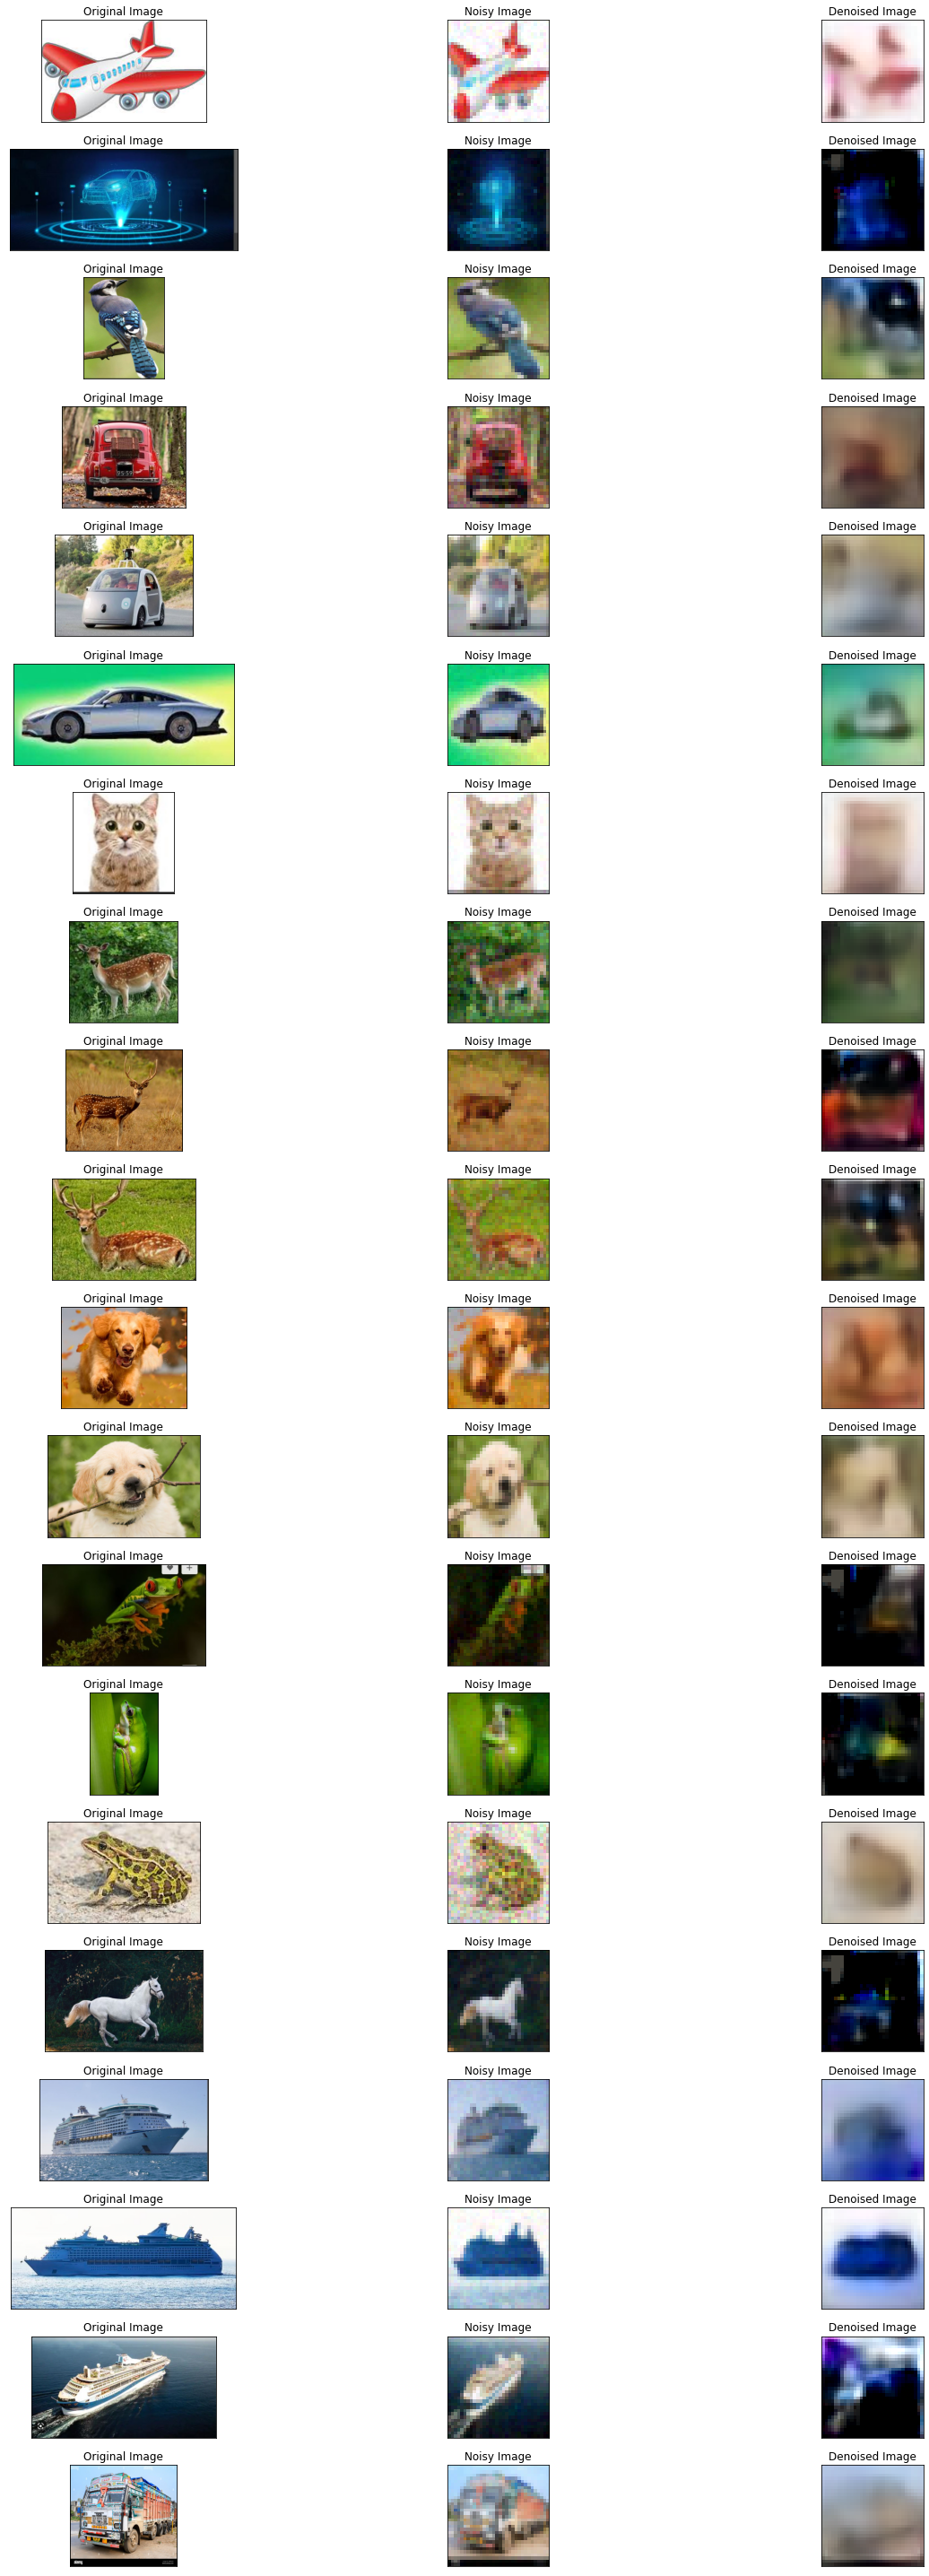

In [10]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from skimage.transform import resize

# Load the saved model
autoencoder = tf.keras.models.load_model('Denoising_Model_Final.h5')

# Set the path to the directory containing the images
image_dir = 'Images/'

# Loop through all image files in the directory
fig = plt.figure(figsize=(20, 40))
counter = 0
for filename in os.listdir(image_dir):
    if filename.endswith('.jpg') or filename.endswith('.jpeg') or filename.endswith('.png') or filename.endswith('.JPG'):

        img_path = os.path.join(image_dir, filename)    
        # Load the image
        img = plt.imread(img_path)
        inpu=img.copy()

        img = img.astype('float32') / 255.

        ## Creating Noisy Image
        noise_factor = 0.5
        img = img + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=img.shape)

        # Resize the image to 32x32
        img_noisy = resize(img, (32, 32))

        # Preprocess the image
        img = np.reshape(img_noisy, (1, 32, 32, 3))

        # Denoise the image
        denoised_img = autoencoder.predict(img)

        # Display the original and denoised image side by side
        ax = fig.add_subplot(len(os.listdir(image_dir)), 3, counter+1, xticks=[], yticks=[])
        ax.imshow(inpu)
        ax.set_title("Original Image")
        counter += 1

        ax = fig.add_subplot(len(os.listdir(image_dir)), 3, counter+1, xticks=[], yticks=[])
        ax.imshow(img_noisy)
        ax.set_title("Noisy Image")
        counter += 1

        ax = fig.add_subplot(len(os.listdir(image_dir)), 3, counter+1, xticks=[], yticks=[])
        ax.imshow(denoised_img[0])
        ax.set_title("Denoised Image")
        counter += 1

plt.tight_layout()
plt.show()
